## Group 1: Final Project - Models on tdcsfog
### Sihe Zheng, szheng12@depaul.edu
### YunTzu Yu, yyu54@depaul.edu
### Saruul Enkhtur, senkhtur@depaul.edu
### Lukasz Grzybek, lgrzybek@depaul.edu


#### DePaul University, College of Computing and Digital Media,
#### DSC 672 DATA SCIENCE CAPSTONE


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import Package

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import IPython
import IPython.display
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import save_model
from tensorflow.keras.models import model_from_json
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, Flatten, Conv1D, MaxPooling1D, Dropout, GRU, SimpleRNN
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
from keras.utils import to_categorical
import gc
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.layers import LSTM
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler

## Function Reduce Memory Usage

In [ ]:
# Reduce Memory Usage
# reference : https://www.kaggle.com/code/arjanso/reducing-dataframe-memory-size-by-65 @ARJANGROEN

def reduce_memory_usage(df):

    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype.name
        if ((col_type != 'datetime64[ns]') & (col_type != 'category')):
            if (col_type != 'object'):
                c_min = df[col].min()
                c_max = df[col].max()

                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)

                else:
                    if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float16)
                    elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        pass
            else:
                df[col] = df[col].astype('category')
    mem_usg = df.memory_usage().sum() / 1024**2
    print("Memory usage became: ",mem_usg," MB")

    return df

## Load and Data Preprosses

In [ ]:
tdcsfog = pd.read_csv('/content/drive/MyDrive/DSC672/finaldataset/full_tdcsfog.csv')

In [ ]:
tdcsfog = reduce_memory_usage(tdcsfog)

Memory usage of dataframe is 646.61 MB
Memory usage became:  127.97441101074219  MB


In [ ]:
tdcsfog

,Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking,Medication,Age,Sex,YearsSinceDx,NFOGQ
0,0,-9.671875,-0.097656,-2.193359,0,0,0,1,69,1,4.0,22
1,1,-9.671875,-0.094604,-2.193359,0,0,0,1,69,1,4.0,22
2,2,-9.671875,-0.092224,-2.187500,0,0,0,1,69,1,4.0,22
3,3,-9.687500,-0.092957,-2.191406,0,0,0,1,69,1,4.0,22
4,4,-9.679688,-0.093140,-2.203125,0,0,0,1,69,1,4.0,22
...,...,...,...,...,...,...,...,...,...,...,...,...
7062667,4220,-9.406250,0.088989,-3.220703,0,0,0,0,65,1,22.0,10
7062668,4221,-9.406250,0.090515,-3.216797,0,0,0,0,65,1,22.0,10
7062669,4222,-9.406250,0.084351,-3.224609,0,0,0,0,65,1,22.0,10
7062670,4223,-9.406250,0.084229,-3.236328,0,0,0,0,65,1,22.0,10


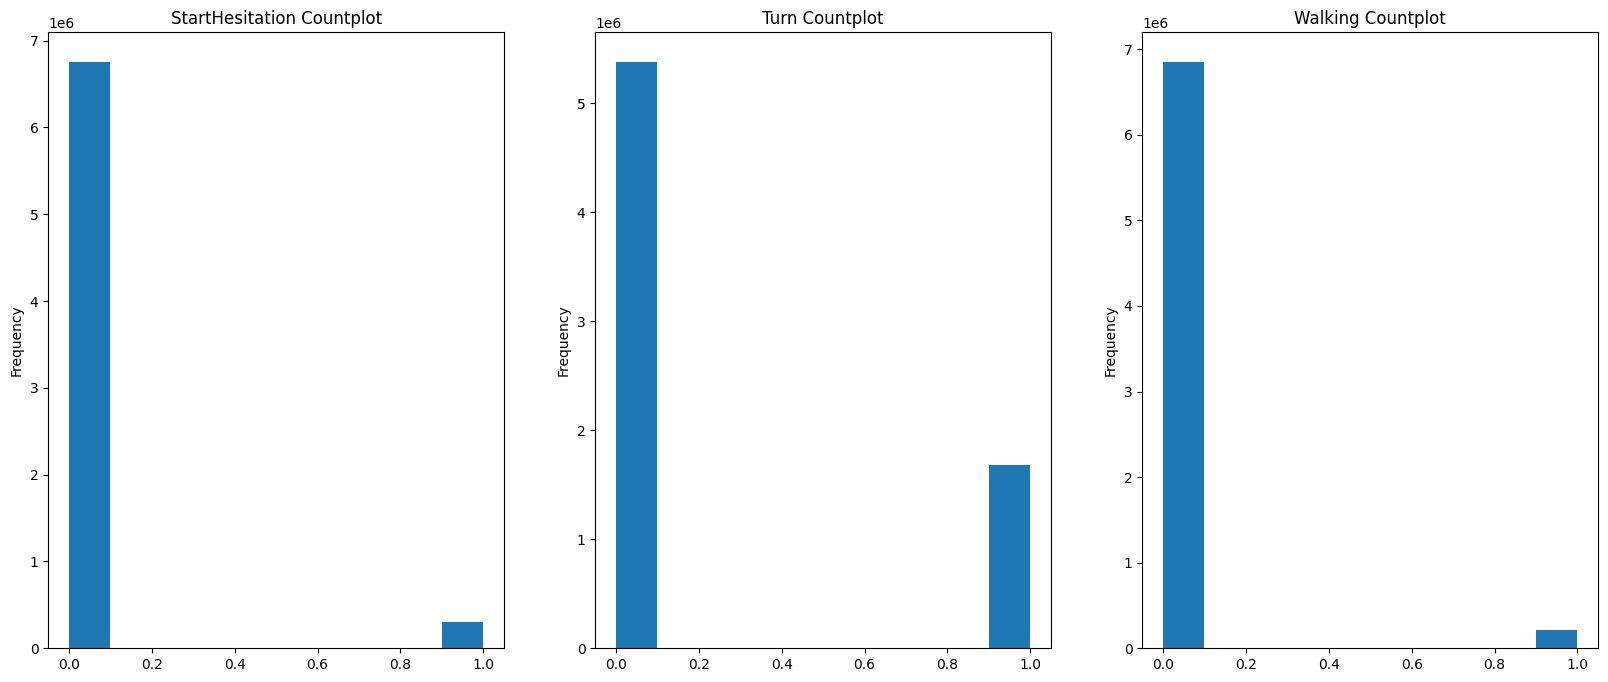

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(20,8))
tdcsfog[['StartHesitation', 'Turn', 'Walking']].StartHesitation.plot(kind='hist', ax=ax[0], title = 'StartHesitation Countplot')
tdcsfog[['StartHesitation', 'Turn', 'Walking']].Turn.plot(kind='hist', ax = ax[1], title = 'Turn Countplot')
tdcsfog[['StartHesitation', 'Turn', 'Walking']].Walking.plot(kind='hist', ax = ax[2], title = 'Walking Countplot')
plt.show()

In [ ]:
def Visualization(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(len(acc))

  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

In [ ]:
def preprocess_data(data):
    # Extract features and target variables
    X = data[['AccV', 'AccML', 'AccAP']].values
    y = data[['StartHesitation', 'Turn', 'Walking']].values

    # Standardize features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Reshape features for LSTM
    X = X.reshape((X.shape[0], 1, X.shape[1]))

    # Convert target variables to integers
    y = np.argmax(y, axis=1)

    # Split data into training and testing sets
    trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.2, random_state=42)

    return trainX, trainy, testX, testy


In [ ]:
trainX, trainy, testX, testy = preprocess_data(tdcsfog)

In [ ]:
# One-hot encode y
trainy_encoded = to_categorical(trainy)
testy_encoded = to_categorical(testy)

# Verify the shape of one-hot encoded labels
print("Shape of trainy_encoded:", trainy_encoded.shape)
print("Shape of testy_encoded:", testy_encoded.shape)

Shape of trainy_encoded: (5650137, 3)
Shape of testy_encoded: (1412535, 3)


In [ ]:
trainy = trainy_encoded.reshape((trainy_encoded.shape[0], 1, trainy_encoded.shape[1]))
testy = testy_encoded.reshape((testy_encoded.shape[0], 1, testy_encoded.shape[1]))

In [ ]:
print('X_train Shape:',trainX.shape)
print('X_test Shape:',testX.shape)
print('y_train Shape:',trainy.shape)
print('y_test Shape:',testy.shape)

X_train Shape: (5650137, 1, 3)
X_test Shape: (1412535, 1, 3)
y_train Shape: (5650137, 1, 3)
y_test Shape: (1412535, 1, 3)


In [ ]:
input_shape = trainX.shape[1:]
input_shape

(1, 3)

In [ ]:
# create a normalization layer and set its internal state using training set
normalizer= keras.layers.experimental.preprocessing.Normalization()
# to compute and store the mean/stdev of each feature
normalizer.adapt(trainX)

## Models

### LSTM model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 3)]            0         
                                                                 
 normalization (Normalizati  (None, 1, 3)              7         
 on)                                                             
                                                                 
 lstm (LSTM)                 (None, 1, 64)             17408     
                                                                 
 dense (Dense)               (None, 1, 3)              195       
                                                                 
Total params: 17610 (68.79 KB)
Trainable params: 17603 (68.76 KB)
Non-trainable params: 7 (32.00 Byte)
_________________________________________________________________
Epoch 1/10
88284/88284 [==============================] - 497s 6ms/step - loss: 0.1343 - a

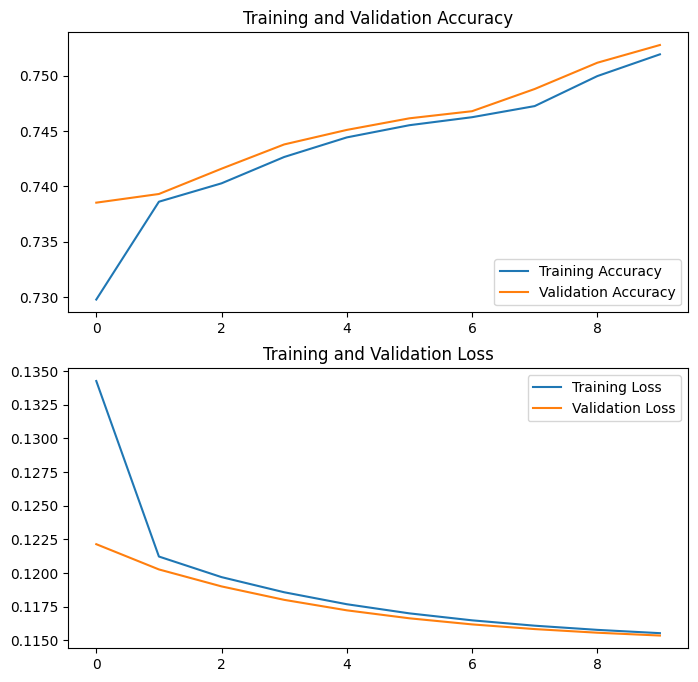

In [ ]:
# defne the input layer with shape (1, 3)-input_shape
inputs = keras.layers.Input(shape=input_shape)

# assiged normalization layer as x, receives the input
x=normalizer(inputs)

#layer
x=keras.layers.LSTM(64,return_sequences=True,activation='relu')(x)

outputs=keras.layers.Dense(3, activation='softmax')(x)

model_LSTM=keras.Model(inputs, outputs)
model_LSTM.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5),
                   loss='mse',
                   metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
model_LSTM.summary()

callback = EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)

history = model_LSTM.fit(trainX, trainy, validation_data=(testX, testy),epochs=10, batch_size=64, verbose=1, callbacks=[callback])

Visualization(history)


In [ ]:
# Evaluate the model on the training data
result_LSTM_train=model_LSTM.evaluate(trainX, trainy)

176567/176567 [==============================] - 445s 3ms/step - loss: 0.1154 - accuracy: 0.7526 - precision: 0.7653 - recall: 0.7320


In [ ]:
# Evaluate the model on the test data
result_LSTM_test=model_LSTM.evaluate(testX, testy)

44142/44142 [==============================] - 112s 3ms/step - loss: 0.1153 - accuracy: 0.7528 - precision: 0.7655 - recall: 0.7322


### GRU Model

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1, 3)]            0         
                                                                 
 normalization (Normalizati  (None, 1, 3)              7         
 on)                                                             
                                                                 
 gru (GRU)                   (None, 1, 64)             13248     
                                                                 
 dense_1 (Dense)             (None, 1, 3)              195       
                                                                 
Total params: 13450 (52.54 KB)
Trainable params: 13443 (52.51 KB)
Non-trainable params: 7 (32.00 Byte)
_________________________________________________________________
Epoch 1/10
88284/88284 [==============================] - 438s 5ms/step - loss: 0.1290 -

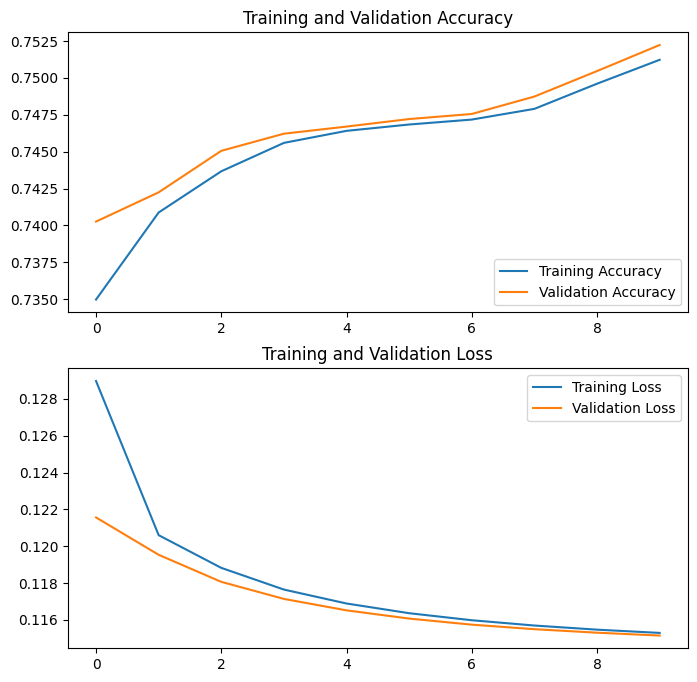

In [ ]:
# defne the input layer with shape (1, 3)-input_shape
inputs1 = keras.layers.Input(shape=input_shape)

# assiged normalization layer as x, receives the input
x1=normalizer(inputs1)

#layer
x1=keras.layers.GRU(64,return_sequences=True,activation='relu')(x1)

outputs1=keras.layers.Dense(3, activation='softmax')(x1)

model_GRU=keras.Model(inputs1, outputs1)
model_GRU.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5),
                   loss='mse',
                   metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

model_GRU.summary()

callback1 = EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)

history1 = model_GRU.fit(trainX, trainy, validation_data=(testX, testy),epochs=10, batch_size=64, verbose=1, callbacks=[callback1])

Visualization(history1)


In [ ]:
result_GRU_train=model_GRU.evaluate(trainX, trainy)

176567/176567 [==============================] - 465s 3ms/step - loss: 0.1152 - accuracy: 0.7522 - precision_1: 0.7646 - recall_1: 0.7323


In [ ]:
result_GRU_test=model_GRU.evaluate(testX, testy)

44142/44142 [==============================] - 117s 3ms/step - loss: 0.1151 - accuracy: 0.7522 - precision_1: 0.7649 - recall_1: 0.7323


### SimpleRNN Model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 3)]            0         
                                                                 
 normalization (Normalizatio  (None, 1, 3)             7         
 n)                                                              
                                                                 
 gru (GRU)                   (None, 1, 64)             13248     
                                                                 
 dense (Dense)               (None, 1, 3)              195       
                                                                 
Total params: 13,450
Trainable params: 13,443
Non-trainable params: 7
_________________________________________________________________
Epoch 1/10
88284/88284 [==============================] - 222s 2ms/step - loss: 0.1302 - accuracy: 0.7317 - precision: 0.74

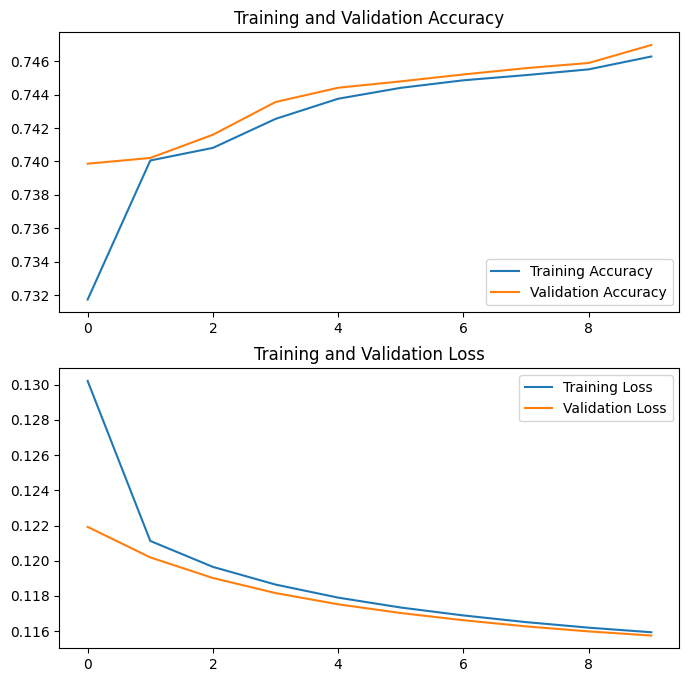

In [ ]:
# defne the input layer with shape (1, 3)-input_shape
inputs2 = keras.layers.Input(shape=input_shape)

# assiged normalization layer as x, receives the input
x2=normalizer(inputs2)

#layer
x2=keras.layers.GRU(64,return_sequences=True,activation='relu')(x2)

outputs2=keras.layers.Dense(3, activation='softmax')(x2)

model_SimpleRNN=keras.Model(inputs2, outputs2)
model_SimpleRNN.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5),
                   loss='mse',
                   metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

model_SimpleRNN.summary()

callback2 = EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)

history2 = model_SimpleRNN.fit(trainX, trainy, validation_data=(testX, testy),epochs=10, batch_size=64, verbose=1, callbacks=[callback2])

Visualization(history2)


In [ ]:
result_srnn_train=model_SimpleRNN.evaluate(trainX, trainy)

176567/176567 [==============================] - 282s 2ms/step - loss: 0.1158 - accuracy: 0.7468 - precision: 0.7586 - recall: 0.7274


In [ ]:
result_srnn_test = model_SimpleRNN.evaluate(testX, testy)

44142/44142 [==============================] - 78s 2ms/step - loss: 0.1157 - accuracy: 0.7470 - precision: 0.7588 - recall: 0.7276


In [ ]:
# Define the data
data = {
    'Model': ['LSTM', 'GRU', 'SimpleRNN'],
    'Train Loss': [result_LSTM_train[0], result_GRU_train[0], result_srnn_train[0]],
    'Train Accuracy': [result_LSTM_train[1], result_GRU_train[1], result_srnn_train[1]],
    'Train Precision': [result_LSTM_train[2], result_GRU_train[2], result_srnn_train[2]],
    'Train Recall': [result_LSTM_train[3], result_GRU_train[3], result_srnn_train[3]],
    'Test Accuracy': [result_LSTM_test[0], result_GRU_test[0], result_srnn_test[0]],
    'Test Loss': [result_LSTM_test[1], result_GRU_test[1], result_srnn_test[1]],
    'Test Precision': [result_LSTM_test[2], result_GRU_test[2], result_srnn_test[2]],
    'Test Recall': [result_LSTM_test[3], result_GRU_test[3], result_srnn_test[3]]
}

# Create DataFrame
df = pd.DataFrame(data)

# Print the DataFrame
df

,Model,Train Loss,Train Accuracy,Train Precision,Train Recall,Test Accuracy,Test Loss,Test Precision,Test Recall
0,LSTM,0.1154,0.7526,0.7653,0.7320,0.1153,0.7528,0.7655,0.7322
1,GRU,0.1152,0.7522,0.7646,0.7323,0.1151,0.7522,0.7649,0.7323
2,SimpleRNN,0.1158,0.7468,0.7586,0.7274,0.1157,0.7470,0.7588,0.7276


The performance of three different recurrent neural network (RNN) architectures, namely LSTM, GRU, and SimpleRNN, was evaluated using various metrics.

For the LSTM model, the training loss was 0.1154 with a training accuracy of 75.26%. It achieved a training precision of 76.53% and a training recall of 73.20%. Similarly, the test loss and accuracy were 0.1153 and 75.28%, respectively, with a test precision of 76.55% and a test recall of 73.22%.

The GRU model exhibited slightly better performance, with a training loss of 0.1152 and a training accuracy of 75.22%. It achieved a training precision of 76.46% and a training recall of 73.23%. The test loss and accuracy were 0.1151 and 75.22%, respectively, with a test precision of 76.49% and a test recall of 73.23%.

On the other hand, the SimpleRNN model showed slightly lower performance compared to LSTM and GRU. It had a training loss of 0.1158 and a training accuracy of 74.68%. The training precision and recall were 75.86% and 72.74%, respectively. The test loss and accuracy were 0.1157 and 74.70%, respectively, with a test precision of 75.88% and a test recall of 72.76%.

Overall, the GRU model performed marginally better than the LSTM and SimpleRNN models across most metrics, followed closely by the LSTM model, while the SimpleRNN model showed slightly lower performance.

### Hyperparameter Search

In [ ]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.6 MB/s eta 0:00:00


In [ ]:
import keras_tuner as kt

In [ ]:
# Define the model-building function
def build_model(hp):

  # Create the input layer
  inputs = tf.keras.Input(shape=(1, 3))

  # Model
  x = layers.GRU(hp.Int('input_unit',min_value=64,max_value=512,step=64),return_sequences=True)(inputs)

  # outputs
  outputs= layers.Dense(3, activation='softmax')(x)

  model = tf.keras.Model(inputs=inputs, outputs=outputs)

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])),
      loss='mse',
      metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

  return model

# Instantiate the tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='model_best',
    project_name='hyperparameter_tuning')

# Define a callback to clear the training outputs at the end of every training step
class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

# Run the hyperparameter search
tuner.search(
    trainX,
    trainy,
    epochs=10,
    validation_data=(testX, testy),
    callbacks=[ClearTrainingOutput()])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""

Best number of input unit: {best_hps.get('input_unit')},
Best learning rate: {best_hps.get('learning_rate')}.

""")


Trial 7 Complete [00h 30m 07s]
val_accuracy: 0.7576187252998352

Best val_accuracy So Far: 0.7580569982528687
Total elapsed time: 02h 54m 12s

Search: Running Trial #8

Value             |Best Value So Far |Hyperparameter
384               |448               |input_unit
1e-05             |0.01              |learning_rate
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/2
176567/176567 [==============================] - 967s 5ms/step - loss: 0.1250 - accuracy: 0.7348 - precision: 0.7485 - recall: 0.7077 - val_loss: 0.1233 - val_accuracy: 0.7381 - val_precision: 0.7494 - val_recall: 0.7206
Epoch 2/2
  7960/176567 [>.............................] - ETA: 15:42 - loss: 0.1236 - accuracy: 0.7371 - precision: 0.7494 - recall: 0.7176

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1, 3)]            0         
                                                                 
 normalization (Normalizatio  (None, 1, 3)             7         
 n)                                                              
                                                                 
 gru_1 (GRU)                 (None, 1, 448)            608832    
                                                                 
 dense_1 (Dense)             (None, 1, 3)              1347      
                                                                 
Total params: 610,186
Trainable params: 610,179
Non-trainable params: 7
_________________________________________________________________
Epoch 1/10
88284/88284 [==============================] - 516s 6ms/step - loss: 0.1139 - accuracy: 0.7562 - precision_1

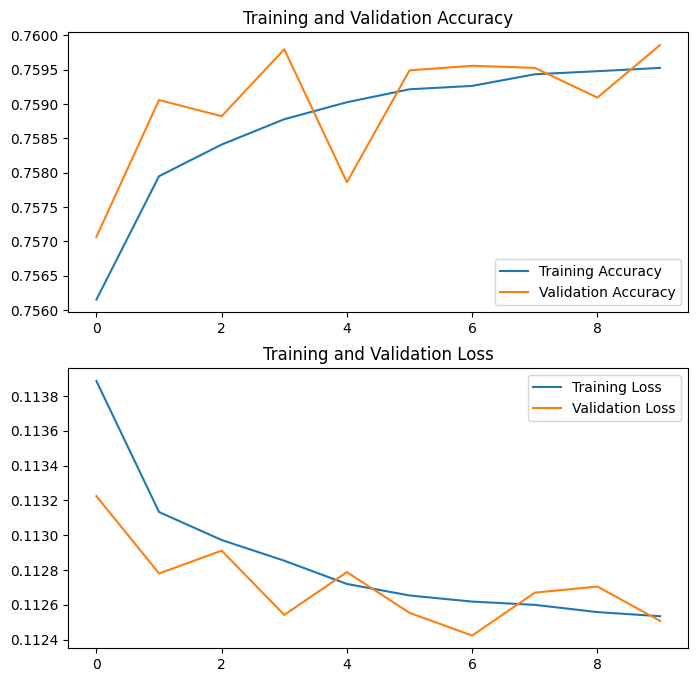

In [ ]:
# defne the input layer with shape (1, 3)-input_shape
inputs1 = keras.layers.Input(shape=input_shape)

# assiged normalization layer as x, receives the input
x1=normalizer(inputs1)

#layer
x1=keras.layers.GRU(448,return_sequences=True,activation='relu')(x1)

outputs1=keras.layers.Dense(3, activation='softmax')(x1)

best_model=keras.Model(inputs1, outputs1)
best_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),
                   loss='mse',
                   metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

best_model.summary()

callback1 = EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)

history1 = best_model.fit(trainX, trainy, validation_data=(testX, testy),epochs=10, batch_size=64, verbose=1, callbacks=[callback1])

Visualization(history1)


In [ ]:
best_model.evaluate(trainX, trainy)

176567/176567 [==============================] - 376s 2ms/step - loss: 0.1125 - accuracy: 0.7597 - precision_1: 0.7766 - recall_1: 0.7338


[0.1125149130821228,
 0.7596962451934814,
 0.7765580415725708,
 0.7337639927864075]

In [ ]:
best_model.evaluate(testX, testy)

44142/44142 [==============================] - 93s 2ms/step - loss: 0.1125 - accuracy: 0.7599 - precision_1: 0.7767 - recall_1: 0.7340


[0.11250674724578857,
 0.7598580121994019,
 0.7766644358634949,
 0.734005868434906]

In [ ]:
train_results=[0.1125149130821228,
 0.7596962451934814,
 0.7765580415725708,
 0.7337639927864075]

test_results=[0.11250674724578857,
 0.7598580121994019,
 0.7766644358634949,
 0.734005868434906]
data = {
    'result': ['Loss', 'Accuracy', 'Precision', 'Recall'],
    'Train': train_results,
    'Test': test_results}

# Create DataFrame
df = pd.DataFrame(data)

# Print the DataFrame
df

,result,Train,Test
0,Loss,0.112515,0.112507
1,Accuracy,0.759696,0.759858
2,Precision,0.776558,0.776664
3,Recall,0.733764,0.734006


### Classification Report for best model

In [ ]:
print('Best Model - Classification Report')
# Predict classes for the test set
y_pred = best_model.predict(testX)
# Convert one-hot encoded predictions to class labels
y_pred_labels = np.argmax(y_pred, axis=2).flatten()
# Convert one-hot encoded true labels to class labels
y_true_labels = np.argmax(testy, axis=2).flatten()
report = classification_report(y_true_labels, y_pred_labels)
print(report)

Best Model - Classification Report
44142/44142 [==============================] - 84s 2ms/step
              precision    recall  f1-score   support

           0       0.78      0.94      0.86   1035368
           1       0.58      0.29      0.39    335820
           2       0.29      0.02      0.04     41347

    accuracy                           0.76   1412535
   macro avg       0.55      0.42      0.43   1412535
weighted avg       0.72      0.76      0.72   1412535

